<a href="https://colab.research.google.com/github/garry-cotton/QFOptionPricingStudy/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import seaborn as sb

from enum import Enum

In [4]:
class Order(Enum):
    LINEAR = 1
    EXPONENTIAL = 2

class Style(Enum):
    DETERMINISTIC = 1
    STOCHASTIC = 2

In [50]:
# Used to generate a path for the interest rate parameter r based
# on various parameters

class InterestRateProcess:
    def __init__(self,
                 order : Order,
                 style : Style,
                 r_start : float,
                 r_end : float = None,
                 dt : float = 0.01,
                 T : float = 1,
                 sigma : float = 1,
                 theta : float = 0.5):

        self.r_start = r_start
        self.r_end = r_start if r_end is None else r_end
        self.sigma = sigma
        self.theta = theta
        self.order = order
        self.style = style
        self.dt = dt
        self.dt_sqrt = np.sqrt(dt)
        self.T = T
        self.N = int(np.ceil(T / dt))

    # Note: change to get property
    def _is_stochastic(self):
        return self.style == Style.STOCHASTIC

    # Note: change to get property
    def _is_exponential(self):
        return self.order == Order.EXPONENTIAL

    def _generate_noise(self):
        return np.random.standard_normal() * self.dt_sqrt * self.sigma

    def _get_drift(self):
        return self.r_end if self._is_exponential() \
            else (self.r_end - self.r_start) / self.T

    def generate_process(self):
        r = np.zeros(self.N)
        r[0] = self.r_start
        mu_r = self._get_drift()
        noise_r = self._generate_noise

        for i in range(1, self.N):
            r_next = mu_r * self.dt

            if self._is_exponential():
                r_next = self.theta * (r_next - r[i-1] * self.dt)

            if self._is_stochastic():
                r_next = r_next + self._generate_noise()

            r[i] = r_next + r[i-1]

        return r

In [72]:
# Used to generate a risk neutral path for a stock S based
# on various parameters

class RiskNeutralStockProcess:
    def __init__(self,
                 r : np.ndarray,
                 sigma : float,
                 S_t : float,
                 dt : float = 0.01,
                 T : float = 10):

        self.r = r
        self.sigma = sigma
        self.S_t = S_t
        self.dt = dt
        self.dt_sqrt = np.sqrt(dt)
        self.T = T
        self.N = int(np.ceil(T / dt))

    def _generate_noise(self):
        return np.random.standard_normal() * self.dt_sqrt * self.sigma

    def generate_process(self):
        S = np.zeros(self.N)
        S[0] = self.S_t
        mu_S = self.r
        noise_S = self._generate_noise

        for i in range(1, self.N):
            S_next = mu_S[i] * self.dt + self._generate_noise()
            S[i] = (S_next + 1) * S[i-1]

        return S

In [109]:
const_r = InterestRateProcess(
    Order.EXPONENTIAL,
    Style.STOCHASTIC,
    dt = 0.0001,
    T = 1,
    r_start = 0.02,
    sigma = 0.01)

const_r_proc = const_r.generate_process()

S = RiskNeutralStockProcess(
    r = const_r_proc,
    sigma = 0.1,
    dt = 0.0001,
    T = 1,
    S_t = 100)

S_proc = S.generate_process()

<Axes: >

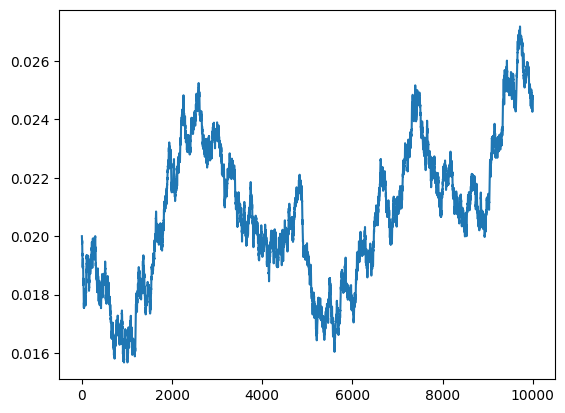

In [110]:
sb.lineplot(const_r_proc)

<Axes: >

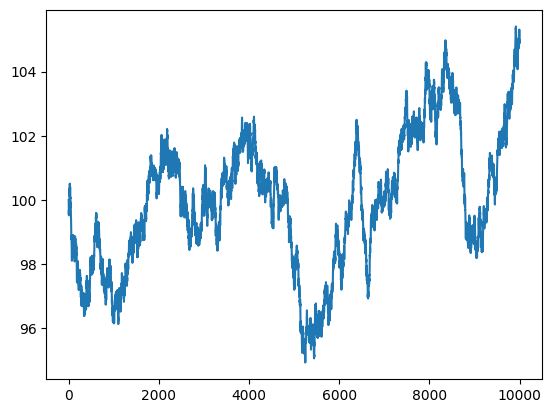

In [111]:
sb.lineplot(S_proc)

In [55]:
r = InterestRateProcess(
    Order.EXPONENTIAL,
    Style.STOCHASTIC,
    dt = 0.01,
    T = 10,
    r_start = 2,
    r_end = 3,
    sigma = 0.1)

r_proc = r.generate_process()

<Axes: >

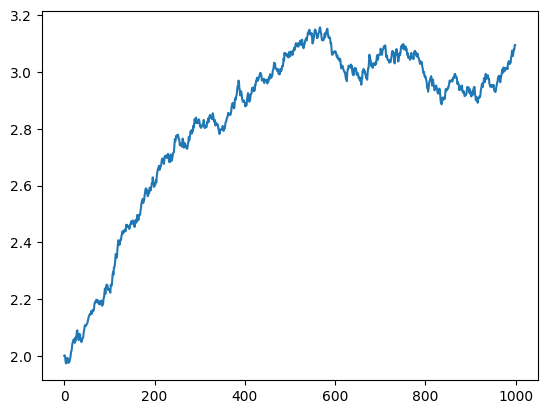

In [56]:
sb.lineplot(r_proc)